# Melbourne housing price prediction

Here,I have used pipeline to make coding compact

In [1]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df=pd.read_csv('melb_data.csv')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [2]:

y = df.Price  #target or dependent variable
X = df.drop(['Price'], axis=1)  #independent variable

In [20]:
import matplotlib.pyplot as plt
from ipywidgets import interact
def plot(feature):
    plt.figure(figsize=(10,7))
    plt.scatter(X[feature],y,color='red',marker='o',edgecolors='black')
    plt.ylabel('Price(log scale)')
    plt.xlabel(feature)
    plt.title(f'scatter plot between price and {feature}',fontweight='bold')
    plt.yscale("log")
menu=X.columns
interact(plot,feature=menu)

interactive(children=(Dropdown(description='feature', options=('Suburb', 'Address', 'Rooms', 'Type', 'Method',…

<function __main__.plot(feature)>

In [27]:
# categorical having caridinal number less than 10
cat_col=[col for col in X.columns if X[col].nunique()<15 and X[col].dtype=='O']
cat_col

['Type', 'Method', 'Regionname']

In [28]:
#numerical columns
num_col=[col for col in X.columns if X[col].dtype in ['int64','float64']]
num_col

['Rooms',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount']

In [29]:
# merging  above both  columns
my_col=num_col+cat_col
X=X[my_col]

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [31]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [32]:
from sklearn.model_selection import KFold


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score



In [33]:
#now i am using stratified cross validation
kfold=KFold(n_splits=5,shuffle=True,random_state=0)

- cross  validation is a statistical method of evaluating generlisation performance  that is more stable 
- In stratified cross validation, we split the dta  data such that proportion between classes are same in each fold.

we can see the difference between these two cross validation in the figure  below

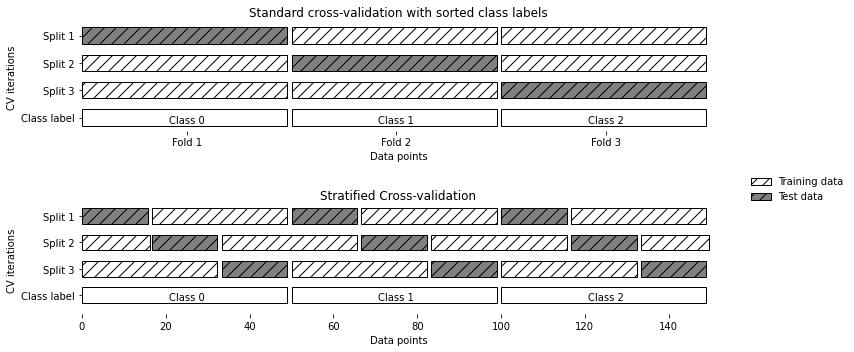

In [10]:

model = RandomForestRegressor() # this is my model with all default parameter
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),  # ceating my pipeline  and passing  two steps
                                  ('model', model)
                                 ])
scores = cross_val_score(my_pipeline, X, y,   # cv=kfold denote stratified cross validation
                                  cv=kfold,
                                  scoring='r2')
   



In [11]:
import numpy as np
print("r 2 scores:\n", np.mean(scores))

r 2 scores:
 0.7942884009123896


# Hypertunning the  model

In [12]:
params={'model__n_estimators':[int(x) for x in np.linspace(100,1000,10)]} # i have used only one parameter beacause of my laptop low ci=omputing power .

        
        
        

In [13]:
model = RandomForestRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])

#scores = cross_val_score(my_pipeline, X, y,cv=kfold,scoring='r2')
random_search=RandomizedSearchCV(my_pipeline,param_distributions=params,n_iter=5,scoring='r2',
                                 n_jobs=-1, cv=kfold,verbose=1)

In [14]:
random_search.fit(X,y) # fitting my model with  random search object

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Postcode',
                                                                                'Bedroom2',
                                                                                'Bathroom',
                                                                                'Car',
                                                                                'Landsize',
                                

In [15]:
random_search.best_params_  #best parameter

{'model__n_estimators': 500}

In [16]:
random_search.best_score_

0.7980423041625861

# xgboost

In [18]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', my_model)
                                 ])
scores = cross_val_score(my_pipeline, X, y,
                                  cv=kfold,
                                  scoring='r2')
   

In [19]:
import numpy as np
print("r 2 scores:\n", np.mean(scores))

r 2 scores:
 0.8078183277391933


Now i will hypertune above model

# Hyper tunning the model

In [34]:
#randmise cv
params={
    'model__n_estimators':[100,200,300,400,500,600,700,800,900,1000 ],
     'model__learning_rate':[0.01,0.02,0.03,0.04,0.05]
    
}

In [35]:
model = XGBRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])

#scores = cross_val_score(my_pipeline, X, y,cv=kfold,scoring='r2')
random_search=RandomizedSearchCV(my_pipeline,param_distributions=params,n_iter=5,scoring='r2',
                                 n_jobs=-1, cv=kfold,verbose=1)

In [36]:
random_search.fit(X,y) # fitting my model with  random search object

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Postcode',
                                                                                'Bedroom2',
                                                                                'Bathroom',
                                                                                'Car',
                                                                                'Landsize',
                                

In [37]:
random_search.best_params_   # best parameter

{'model__n_estimators': 500, 'model__learning_rate': 0.04}

In [38]:
random_search.best_score_  # best score

0.8198212797125034